# 1. Data Cleaning

In [108]:
# Imports
import os
import re
import copy
import numpy as np
import pdfplumber
import pandas as pd
import nltk
import openai
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

In [109]:
pdf_dir = "./data"
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
docsSorted = sorted(pdf_files, key=lambda x: (int(x.split('doc')[1].split('.pdf')[0])))
pdf_files=docsSorted
title_abstract_list = []

In [110]:
def extract_title_abstract(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[0]

        text = page.extract_text(x_tolerance=1, y_tolerance=5)

        # print(page.chars)
        table={}
        for x,i in enumerate(page.chars):
            # print(i["text"])
            # if i["text"]==" " or i["text"]=="\n":
            #     print("new line")
            if i["size"] not in table:
                table[i["size"]]=""
            if x>0 and i["x0"]-page.chars[x-1]["x1"]>=1:
                table[i["size"]]+=" "
            if x>0 and page.chars[x-1]["y1"]-i["y1"]>5:
                table[i["size"]]+=" "
            table[i["size"]]+=i["text"]


        # print(text,"\n") 
        tmp=copy.deepcopy(table)

        for i in tmp:
            if len(tmp[i])<30:
                del table[i]

        title=table[max(table.keys())].strip().replace("  "," ")
        abstract_match = re.search(r"Abstract\s+(.*?[.!?])\s*\n[c,©]", text, re.DOTALL)
        if not abstract_match:
            abstract_match = re.search(r'(?i)abstract\b\.?:?]?\s+((?:.|\n)+?)(?=\n\d+\.|Key|Introduction|[0,1]?\Z)', text, re.DOTALL)

        if abstract_match:
            abstract = abstract_match.group(1).strip()

    if not abstract_match:
        abstract = "No abstract found"
    return title, abstract

In [111]:
def get_text_from_pdf(pdf_path):
    allText=""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
             allText+=page.extract_text(x_tolerance=1, y_tolerance=5)
    return allText

lemmatizer=WordNetLemmatizer()


def preprocess_text(text):
    words=word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered= [lemmatizer.lemmatize(w.lower()) for w in words if not w.lower() in stop_words and w.isalpha()]
    return filtered


# 2. Embeddings

In [112]:
load_dotenv()
openai.api_key = os.getenv("KEY")

In [113]:
embeddings={}

def get_embedding(text, model="text-embedding-ada-002"):
   return openai.Embedding.create(input = text, model=model)['data'][0]['embedding']

for i in pdf_files:
    text=get_text_from_pdf("./data/"+i)
    filtered=" ".join(preprocess_text(text))
    if len(filtered)>8192:
        filtered=filtered[:8192]
    embeddings[i]=get_embedding(filtered)

    

In [114]:
import random

random_indices = random.sample(range(len(pdf_files)), 5)
random_indices

[28, 18, 26, 20, 6]

In [115]:
random_embeddings = np.array([embeddings[pdf_files[i]] for i in random_indices])
random_documents = [pdf_files[i] for i in random_indices]

In [116]:
for i,j in zip(random_documents,random_embeddings):
    print('Most similar documents to Document', i, 'are:')
    table={}
    for k,l in embeddings.items():
        if k!=i:
            j=np.array(j).reshape(1,-1)
            l=np.array(l).reshape(1,-1)
            table[k]=cosine_similarity(j,l)
    table=sorted(table.items(), key=lambda x: x[1], reverse=True)
    for k in table[:3]:
        print("Document:",k[0],"Similarity:",k[1][0][0])


Most similar documents to Document doc29.pdf are:
Document: doc27.pdf Similarity: 0.9340821782666336
Document: doc25.pdf Similarity: 0.9286766672086715
Document: doc28.pdf Similarity: 0.9194989694805524
Most similar documents to Document doc19.pdf are:
Document: doc20.pdf Similarity: 0.9210809348739525
Document: doc1.pdf Similarity: 0.9175053573109256
Document: doc22.pdf Similarity: 0.9142233703169047
Most similar documents to Document doc27.pdf are:
Document: doc29.pdf Similarity: 0.9340821782666336
Document: doc25.pdf Similarity: 0.9297030888970558
Document: doc32.pdf Similarity: 0.9208689723476489
Most similar documents to Document doc21.pdf are:
Document: doc17.pdf Similarity: 0.9256122066899417
Document: doc14.pdf Similarity: 0.9135663390536732
Document: doc12.pdf Similarity: 0.9113978000325069
Most similar documents to Document doc7.pdf are:
Document: doc6.pdf Similarity: 0.9455957445779382
Document: doc8.pdf Similarity: 0.9324303207551707
Document: doc23.pdf Similarity: 0.929492

Using Doc2Vec for Document Similarity

In [117]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec

In [118]:

dataD2V = []

for i in docsSorted:
    text=get_text_from_pdf("./data/"+i)
    dataD2V.append(" ".join(preprocess_text(text)))

dataD2VTagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(dataD2V)]

In [119]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
model.build_vocab(dataD2VTagged)
model.train(dataD2VTagged, total_examples=model.corpus_count, epochs=80)
model.save("DocsSimilarity.model")
model = Doc2Vec.load("DocsSimilarity.model")

In [120]:
for i in random_indices:
      docNum = i 
      similar_doc = model.dv.most_similar(str(docNum), topn=3)
      print("Selected Document", docsSorted[docNum-1])
      print("Array Featuring Three Most Similar Docs", similar_doc)
      print("Names of Three Most Similar Documents:", docsSorted[int(similar_doc[0][0])-1] + "  " +
            docsSorted[int(similar_doc[1][0])-1] + "  " + docsSorted[int(similar_doc[2][0])-1])

Selected Document doc28.pdf
Array Featuring Three Most Similar Docs [('20', 0.6554245352745056), ('29', 0.5022996664047241), ('16', 0.4411569833755493)]
Names of Three Most Similar Documents: doc20.pdf  doc29.pdf  doc16.pdf
Selected Document doc18.pdf
Array Featuring Three Most Similar Docs [('22', 0.543062686920166), ('19', 0.5159586071968079), ('21', 0.4584735035896301)]
Names of Three Most Similar Documents: doc22.pdf  doc19.pdf  doc21.pdf
Selected Document doc26.pdf
Array Featuring Three Most Similar Docs [('24', 0.30879372358322144), ('28', 0.282298743724823), ('6', 0.26530924439430237)]
Names of Three Most Similar Documents: doc24.pdf  doc28.pdf  doc6.pdf
Selected Document doc20.pdf
Array Featuring Three Most Similar Docs [('28', 0.6554245352745056), ('23', 0.3062486946582794), ('7', 0.2806243300437927)]
Names of Three Most Similar Documents: doc28.pdf  doc23.pdf  doc7.pdf
Selected Document doc6.pdf
Array Featuring Three Most Similar Docs [('14', 0.46030041575431824), ('5', 0.420

# 3. Dimensionality Reduction

In [121]:
df=pd.DataFrame(embeddings.items(),columns=["file","embedding"])
df

,file,embedding
0,doc1.pdf,"[-0.007468653377145529, 0.006924919318407774, ..."
1,doc2.pdf,"[-0.007768097799271345, 0.029004478827118874, ..."
2,doc3.pdf,"[-0.013151709921658039, 0.022919991984963417, ..."
3,doc4.pdf,"[-0.016222864389419556, 0.020481882616877556, ..."
4,doc5.pdf,"[-0.020745903253555298, 0.015206421725451946, ..."
5,doc6.pdf,"[-0.017928726971149445, 0.016784340143203735, ..."
6,doc7.pdf,"[-0.00853014551103115, 0.018714874982833862, -..."
7,doc8.pdf,"[-0.018409205600619316, 0.021014027297496796, ..."
8,doc9.pdf,"[-0.02253408171236515, 0.014514884911477566, -..."
9,doc10.pdf,"[-0.011275878176093102, 0.007968286983668804, ..."


In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

matrix=np.array(list(embeddings.values()))
scaled=StandardScaler().fit_transform(matrix)


pca=PCA(n_components=2)

reduced=pca.fit_transform(scaled)
df["reduced2D"]=reduced.tolist()

pca=PCA(n_components=30)

reduced30=pca.fit_transform(scaled)
df["reduced30D"]=reduced30.tolist()

# 4. Clustering

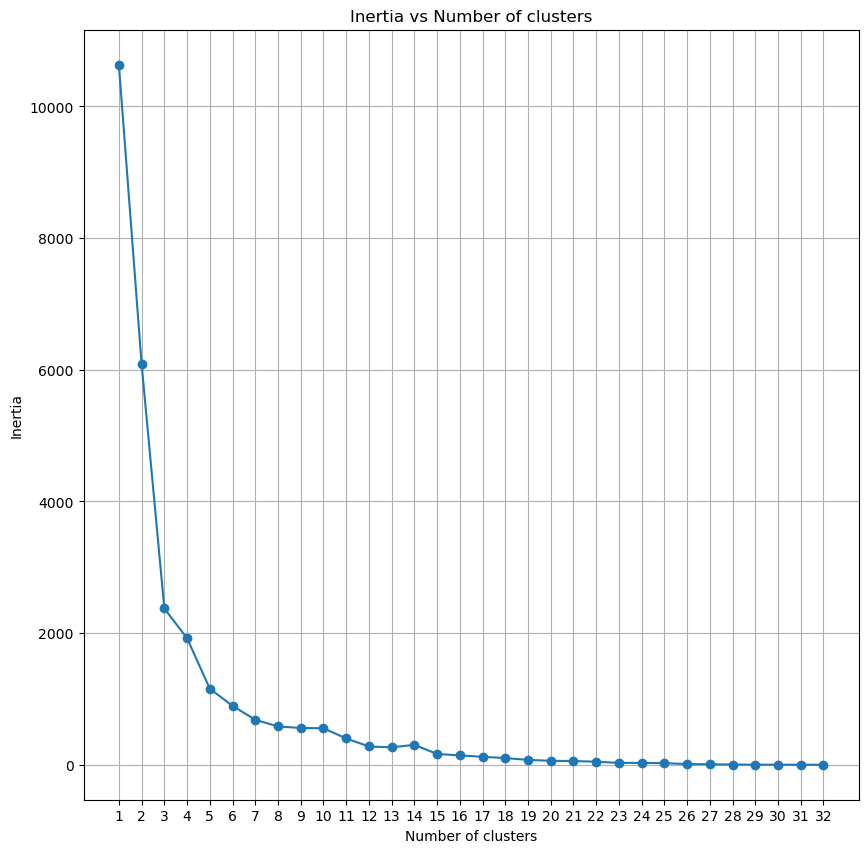

In [123]:
from sklearn.cluster import KMeans
intertia=[]


for i in range(1,33):
    KM=KMeans(n_clusters=i, n_init="auto").fit(df['reduced2D'].tolist())
    intertia.append(KM.inertia_)

plt.figure(figsize=(10,10))
plt.plot(range(1,33),intertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,33))
plt.title('Inertia vs Number of clusters')
plt.grid(True)
plt.show()

Using the elbow method to find the optimal number of clusters we can see that the optimal number of clusters is 5.

In [132]:
clustering=KMeans(n_clusters=5, n_init="auto").fit(df["reduced30D"].tolist())
centroids = clustering.cluster_centers_
df["cluster"]=clustering.labels_
df

,file,embedding,reduced2D,reduced30D,cluster
0,doc1.pdf,"[-0.007468653377145529, 0.006924919318407774, ...","[14.236398153618714, 2.057793280338458]","[14.236395274030928, 2.0576063734644015, -4.06...",3
1,doc2.pdf,"[-0.007768097799271345, 0.029004478827118874, ...","[-1.6362809248123857, 5.037635715885062]","[-1.6363874900204187, 5.036812908193946, 9.141...",2
2,doc3.pdf,"[-0.013151709921658039, 0.022919991984963417, ...","[5.176482337938817, -14.096164791776095]","[5.1764771073935, -14.095148478004289, 3.10674...",0
3,doc4.pdf,"[-0.016222864389419556, 0.020481882616877556, ...","[10.583828880330802, -2.304313749116313]","[10.583784031135066, -2.3057415933806724, -8.5...",3
4,doc5.pdf,"[-0.020745903253555298, 0.015206421725451946, ...","[3.962597817896846, -7.92820628031292]","[3.9625836983935305, -7.92534502535145, -2.932...",2
5,doc6.pdf,"[-0.017928726971149445, 0.016784340143203735, ...","[25.10570087461127, -0.2873238519759452]","[25.105763346152905, -0.2862951978557349, -15....",3
6,doc7.pdf,"[-0.00853014551103115, 0.018714874982833862, -...","[16.93692357644779, -2.079428025345205]","[16.936893738260594, -2.0782546364000685, -9.6...",3
7,doc8.pdf,"[-0.018409205600619316, 0.021014027297496796, ...","[21.73996588987623, -0.2153862198542066]","[21.739972726439646, -0.21559139311795067, -9....",3
8,doc9.pdf,"[-0.02253408171236515, 0.014514884911477566, -...","[-16.714531062062683, -13.710779221894406]","[-16.714529769771364, -13.711344892717598, 12....",2
9,doc10.pdf,"[-0.011275878176093102, 0.007968286983668804, ...","[-17.083687557172677, -15.436619554572186]","[-17.08371662135625, -15.435863541869033, -4.1...",2


In [133]:
from scipy.spatial import distance
cluster_info = pd.DataFrame(columns=['Cluster number', 'Representative documents'])
clustered={}
for i, centroid in enumerate(centroids):
    distances = distance.cdist([centroid], df['reduced30D'].tolist(), 'euclidean')[0]
    closest_indices = distances.argsort()
    representatives = []
    count=0
    j=0
    while(count!=3 and j!=len(closest_indices)):
        if df.iloc[closest_indices[j]]['cluster']==i:
            title, abstract = extract_title_abstract("./data/"+df['file'][closest_indices[j]])
            representatives.append(df['file'][closest_indices[j]]+" | "+title + " | " + abstract)
            representative_docs = "\n".join(representatives)
            count+=1
        j+=1
    cluster_info = cluster_info.append({'Cluster number': i, 'Representative documents': representative_docs}, ignore_index=True)
    
cluster_info.to_csv('cluster_info.csv', index=False)

In [134]:
clustering=KMeans(n_clusters=5, n_init="auto").fit(df["reduced2D"].tolist())
centroids = clustering.cluster_centers_
x = [p[0] for p in df['reduced2D']]
y = [p[1] for p in df['reduced2D']]

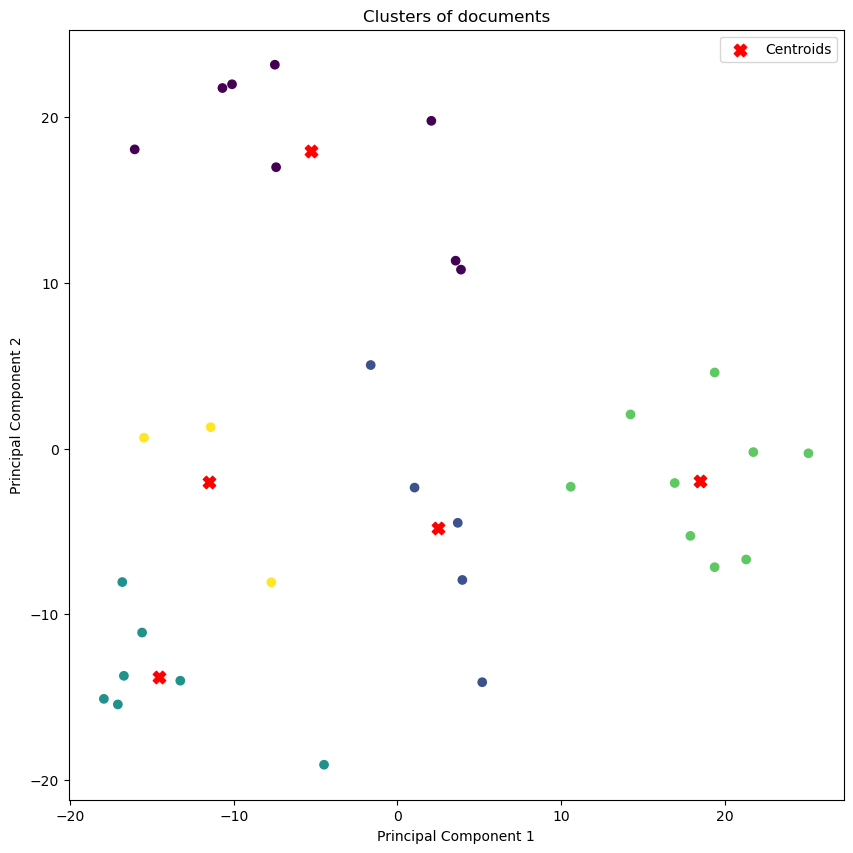

In [135]:
plt.figure(figsize=(10,10))
plt.scatter(x, y, c=clustering.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=80, label='Centroids')
plt.title('Clusters of documents')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.savefig('clusters.png')
plt.show()
plt.close()

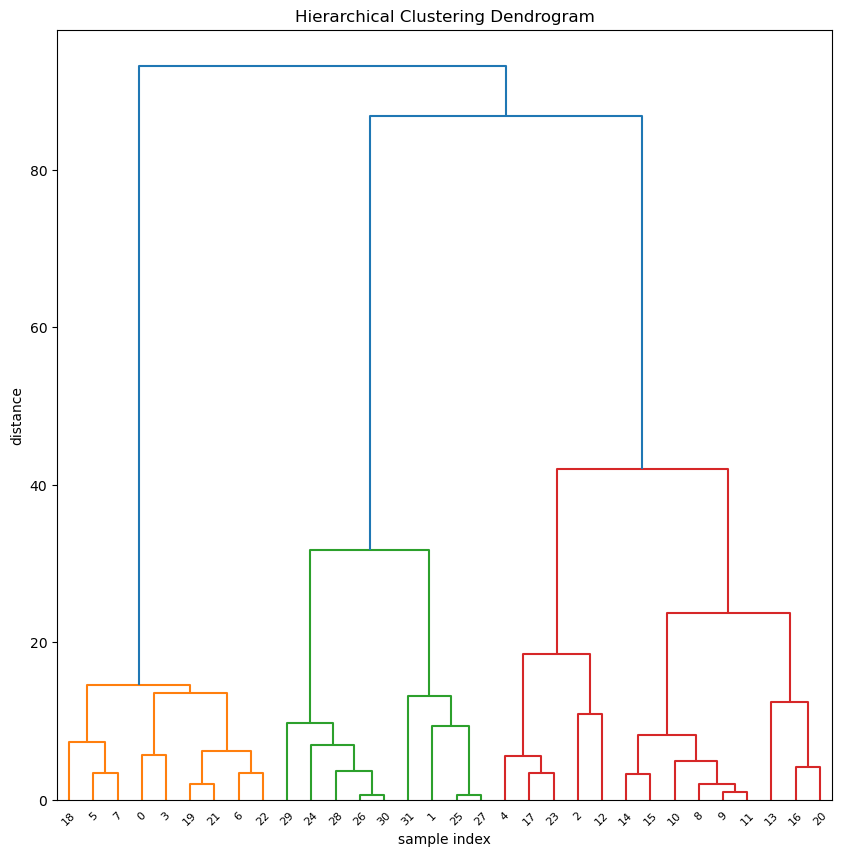

In [136]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(reduced, method='ward') 



plt.figure(figsize=(10, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

And this is how it would look with 4 clusters.

# 5. Class-based TF-IDF

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

class ClassBasedTFIDF:
    def __init__(self, docs, clsts):
        self.docs = docs
        self.clsts = clsts
        self.clstDocs = self.docsMergeByClst()
        self.tfIdfMat, self.feature_names = self.tfIdf()
        self.topWords = self.getTopKeys()

    def docsMergeByClst(self):
        clstDocs = {}
        for doc, clst in zip(self.docs, self.clsts):
            if clst not in clstDocs:
                clstDocs[clst] = ""
            clstDocs[clst] += " " + doc
        return clstDocs

    def tfIdf(self):
        vectorizer = TfidfVectorizer()
        docs = [doc for doc in self.clstDocs.values()]
        tfIdfMat = vectorizer.fit_transform(docs)
        featNames = vectorizer.get_feature_names_out()
        return tfIdfMat, featNames

    def getTopKeys(self, top_n=6):
        topWords = {}
        for clst, doc in self.clstDocs.items():
            row = self.clsts.index(clst)
            scores = np.array(self.tfIdfMat[row-1].todense()).flatten()
            sorted_indices = np.argsort(scores)[::-1][:top_n]
            keywords = [self.feature_names[index] for index in sorted_indices]
            topWords[clst] = keywords
        return topWords

    def csvAdd(self, fName='cluster_info.csv'):
        data = []
        for clst, keywords in self.topWords.items():
            repDocChars = self.clstDocs[clst][:100]  # Assuming you want the first 100 chars as representative
            data.append([clst, repDocChars, ", ".join(keywords)])
        df = pd.DataFrame(data, columns=['Cluster number', 'Representative documents', 'Top keywords'])
        df.to_csv(fName, index=False)

In [138]:
docTexts = ["","","","",""]

for c,i in enumerate(docsSorted):
    clus=df.iloc[c]['cluster']
    text=get_text_from_pdf("./data/"+i)
    docTexts[clus]+=(" ".join(preprocess_text(text)))
tfidf_obj = ClassBasedTFIDF(docTexts, [0,1,2,3,4])
tfidf_obj.csvAdd()

# 6. Improve topic representations